# AI&ML Homework 1 - prof. Caputo 2018/2019
This is the final report Homework 1 of "Machine Learning and Artificial Intelligence" course taught by Prof. Barbara Caputo.
## Data Preparation
In this first step, I was asked to prepare the images for the elaboration. The dataset was made by 1087 samples with 3x227x227 sample size which belong to 4 visual object categories.
I extracted all the files in the folder `PACS_homework` in the root folder of my workspace. In order to make the elaboration faster, I used 4 threads (one for every categories) and I decided to save the images and the labels in two file in order to make next loadings faster.

In [1]:
%matplotlib inline

In [2]:
# %load standardize.py
import numpy as np


class Standardize(object):
    __mean = None
    __std = None

    def standardize(self, data):
        new = np.array(data)
        self.__mean = np.mean(new, axis=0)
        self.__std = np.std(new, axis=0)
        new = (new - self.__mean) / self.__std
        return new

    def destandardize(self, data):
        new = np.array(data)
        new = new * self.__std + self.__mean
        return new


In [3]:
# %load PACS_loading.py
from PIL import Image
import numpy as np
import threading
import os


def gen_matrix(path_dir):
    o_dog = [np.empty((0, 154587)), np.empty((0, 1))]
    o_guitar = [np.empty((0, 154587)), np.empty((0, 1))]
    o_house = [np.empty((0, 154587)), np.empty((0, 1))]
    o_person = [np.empty((0, 154587)), np.empty((0, 1))]

    threads = [
        threading.Thread(target=add_data_to_matrix,
                         args=(o_dog, path_dir, "dog", "red")),
        threading.Thread(target=add_data_to_matrix,
                         args=(o_guitar, path_dir, "guitar", "yellow")),
        threading.Thread(target=add_data_to_matrix,
                         args=(o_house, path_dir, "house", "blue")),
        threading.Thread(target=add_data_to_matrix,
                         args=(o_person, path_dir, "person", "green"))
    ]

    for t in threads:
        t.start()
    for t in threads:
        t.join()
    X = np.vstack((o_dog[0], o_guitar[0], o_house[0], o_person[0]))
    y = np.vstack((o_dog[1], o_guitar[1], o_house[1], o_person[1]))
    np.save(path_dir + "data.npy", X)
    np.save(path_dir + "label.npy", y)
    return X, y


def load_matrix(path_data, path_label):
    X = np.load(path_data)
    y = np.load(path_label)
    return X, y


def add_data_to_matrix(list, PACS_dir, folder_name, color):
    print('Loading ' + folder_name + '...')
    path_dir = PACS_dir + folder_name
    directory = os.fsencode(path_dir)
    lst = os.listdir(directory)
    lst.sort()
    for file in lst:
        filename = os.fsdecode(file)
        if filename.endswith(".jpg"):
            img_data = np.asarray(Image.open(os.path.join(path_dir, filename)))
            list[0] = np.vstack((list[0], img_data.ravel()))
            list[1] = np.vstack((list[1], color))
            # print(filename)
            continue
        else:
            continue
    print(folder_name + 'loaded correctly!')


Loading dog...
Loading guitar...
Loading house...
Loading person...
guitar loaded correctly!
dog loaded correctly!
house loaded correctly!
person loaded correctly!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


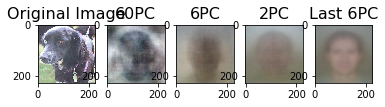

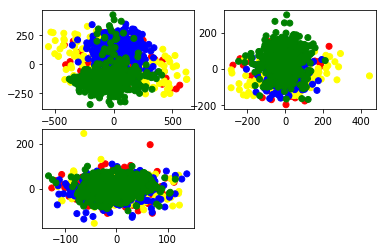

end


In [4]:
# %load main.py
import numpy as np
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from standardize import Standardize
import PACS_loading as PACS


def pca_custom(X):
    """
    Principal Component Analysis
    input: X, matrix with training data stored as flattened arrays in rows
    return: projection matrix (with important dimensions first), variance
    and mean.
    """
    # get dimensions
    num_data, dim = X.shape
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X

    # PCA - compact trick used
    M = np.dot(X, X.T)  # covariance matrix, AA', not the A'A like usual
    e, EV = np.linalg.eigh(M)  # compute eigenvalues and eigenvectors
    tmp = np.dot(X.T, EV).T  # this is the compact trick
    V = tmp[::-1]  # reverse since last eigenvectors are the ones we want
    S = np.sqrt(e)[::-1]  # reverse since eigenvalues are in increasing order
    for i in range(V.shape[1]):
        V[:, i] /= S  # What for?

    # return the projection matrix, the variance and the mean
    return V, S, mean_X


def reconstruction(X_t, image_id, st, nComp):
    if nComp > 0:
        X_b = np.dot(X_t[:, :nComp], pca.components_[:nComp, :])
    else:
        X_b = np.dot(X_t[:, nComp:], pca.components_[nComp:, :])

    orig = st.destandardize(X_b) / 255
    orig.astype(np.float32)
    return orig[image_id].reshape(227, 227, 3)


# Start of the program for Jupyter
X, y = PACS.gen_matrix('./PACS_homework/')

# Standardize the features
st = Standardize()
X_n = st.standardize(X)

pca = PCA()
pca.fit(X_n)

# Create the figure and set id of the image
plt.figure(0)
image_id = 2

X_t = pca.transform(X_n)

# Plot Original Image
plt.subplot(2, 5, 1)
orig = st.destandardize(X_n) / 255
orig.astype(np.float32)
plt.imshow(orig[image_id].reshape(227, 227, 3), vmin=0, vmax=1)
plt.title('Original Image', fontsize=16)

# Plot 60PC Image
plt.subplot(2, 5, 2)
plt.imshow(reconstruction(X_t, image_id, st, 60), vmin=0, vmax=1)
plt.title('60PC', fontsize=16)

# Plot 6PC Image
plt.subplot(2, 5, 3)
plt.imshow(reconstruction(X_t, image_id, st, 6), vmin=0, vmax=1)
plt.title('6PC', fontsize=16)

# Plot 2PC Image
plt.subplot(2, 5, 4)
plt.imshow(reconstruction(X_t, image_id, st, 2), vmin=0, vmax=1)
plt.title('2PC', fontsize=16)

# Plot Last 6PC Image
plt.subplot(2, 5, 5)
plt.imshow(reconstruction(X_t, image_id, st, -6), vmin=0, vmax=1)
plt.title('Last 6PC', fontsize=16)

plt.figure(1)
plt.subplot(2, 2, 1)
plt.scatter(X_t[:, 0], X_t[:, 1], c=y.ravel())
plt.subplot(2, 2, 2)
plt.scatter(X_t[:, 3], X_t[:, 4], c=y.ravel())
plt.subplot(2, 2, 3)
plt.scatter(X_t[:, 10], X_t[:, 11], c=y.ravel())
plt.show()
print("end")
